In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### dir setting

In [0]:
dir = '/content/drive/My Drive/Colab Notebooks/data'

# game tag filtering

In [0]:
game = pd.read_csv (dir + '/game_list.csv', encoding = 'utf-8', header = 0)
tag = pd.read_csv (dir + '/game_tag.csv', encoding = 'utf-8', header = 0)

FileNotFoundError: ignored

In [0]:
game = game.sort_values(by = 'review_count', axis = 0, ascending = False)
game = game[game['review_count'] > 500]
tag = tag['game_id'].unique()
len_before = len(game)
game = game[game['game_id'].isin(tag)]
len_after = len(game)
print (len_before, "->", len_after)
print ("No Tag: ", "%.3f"%((len_before - len_after) / len_before * 100) , "%")

3506 -> 3398
No Tag:  3.080 %


In [0]:
game = game.reset_index(drop = True)
game

In [0]:
game.to_csv (dir + "./game_list_valid.csv", encoding = 'utf-8', index = False, columns = ['game_id', 'review_count'])

# game play scoring

In [0]:
df_pt = pd.read_csv (dir + '/user_playtime_filtered.csv', encoding = 'utf-8', header = 0)
df_vt = pd.read_csv (dir +'/user_vote_filtered.csv', encoding = 'utf-8', header = 0)

In [4]:
my_df = pd.merge (df_pt, df_vt, how = 'outer', on = ['game_id', 'user_id'])
my_df = my_df.fillna(0)
my_df = my_df [(my_df['play_time'] != 0)]
my_df['score'] = np.log10 (my_df['play_time']+1) # +my_df['vote'] * 3
my_df = my_df.reset_index(drop = True)
# pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')
my_df

,user_id,game_id,play_time,vote,score
0,76561198077358609,4000,13730.0,0.0,4.137702
1,76561198077358609,10500,775.0,0.0,2.889862
2,76561198077358609,48700,23790.0,1.0,4.376413
3,76561198077358609,33900,129.0,0.0,2.113943
4,76561198077358609,33930,4637.0,1.0,3.666331
...,...,...,...,...,...
1509802,76561198075128862,8500,311.0,0.0,2.494155
1509803,76561198075128862,564710,216.0,0.0,2.336460
1509804,76561198075128862,588950,124.0,0.0,2.096910
1509805,76561198075128862,597220,1090.0,0.0,3.037825


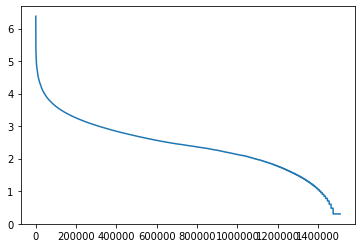

In [5]:
plt.plot (my_df.index, my_df.sort_values(by = 'score', ascending = False)['score'])

In [0]:
split_n = 5
cut = [-100]
for i in range (1, split_n) :
    cut.append (np.percentile (my_df['score'], 100 * i / split_n))

cut

def f_cut (x) :
    for i in range(split_n) :
        if x <= cut[i] :
            return i
    return split_n

In [0]:
my_df['rating'] = my_df['score'].apply(f_cut)

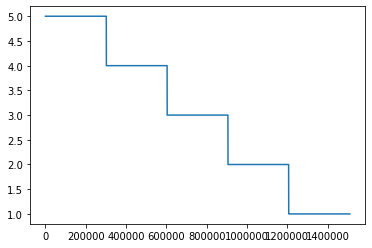

In [0]:
plt.plot (my_df.index, my_df.sort_values(by = 'rating', ascending = False)['rating'])

# CF

In [0]:
!pip install surprise

     |████████████████████████████████| 6.5MB 2.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678226 sha256=d27779d488a7ecf1bcadfa3612d22b299253d46aae0d1d4c88e0643a9ffb46a0
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
import surprise
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split
from surprise import accuracy

In [0]:
# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(1, len(my_df)))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(my_df[['user_id', 'game_id', 'rating']], reader)

In [0]:
bsl_options = {
    'method': 'als',
    'n_epochs': 5,
    'reg_u': 12,
    'reg_i': 5
}
sim_options = {
    'user_based' : False
}

algo = surprise.BaselineOnly(bsl_options = bsl_options)

In [0]:
bsl_options = {'method': 'als',
               'n_epochs': 20,
               }
sim_options = {'name': 'pearson_baseline'}
algo = surprise.KNNBasic(bsl_options=bsl_options, sim_options=sim_options)

In [0]:
algo = surprise.SVD()

In [0]:
algo = surprise.NormalPredictor()

In [0]:
# We can now use this dataset as we please, e.g. calling cross_validate
cross_validate(algo, data, cv=2)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...


In [0]:
trainset, testset = train_test_split(data, test_size=.25)

In [0]:
algo.fit(trainset)
predictions = algo.test(testset)

In [0]:
pr = [{'user_id' : i.uid, 'game_id' : i.iid, 'r' : i.est} for i in predictions]
df_pr = pd.DataFrame (pr, columns = ['user_id', 'game_id', 'r'])
df = pd.merge (my_df, df_pr, how = 'right', on = ['game_id', 'user_id'])
df['r'] = df['r'].apply (np.around)

In [0]:
len(df[df['r'] == df['rating']]) / len (df)

In [0]:
accuracy.rmse(predictions, verbose=True)

# Classification Form

In [0]:
game_list = my_df['game_id'].drop_duplicates().reset_index (drop = True)
user_list = my_df['user_id'].drop_duplicates().reset_index (drop = True)
tag = pd.read_csv (dir + '/game_tag.csv', encoding = 'utf-8', header = 0)

In [0]:
tag['p'] = 1
tag = pd.pivot_table(tag, index = 'game_id', columns = 'tag', values = 'p', aggfunc = np.mean).fillna(0)

In [0]:
game = pd.merge (game_list, tag, how = 'left', on = ['game_id'])
game_pt = pd.pivot_table(df_pt, index = 'game_id', columns = 'user_id', values = 'play_time', aggfunc = np.mean).fillna(0)

a = game_pt[game_pt > 120]

pt_Q3 = a.quantile (0.75, axis = 1)
pt_Q2 = a.quantile (0.5, axis = 1)
pt_Q1 = a.quantile (0.25, axis = 1)

game_pt ['Q3'] = pt_Q3
game_pt ['Q2'] = pt_Q2
game_pt ['Q1'] = pt_Q1

game_pt ['player'] = np.sum ((game_pt > 120), axis = 1)
game = pd.merge (game, game_pt[['player', 'Q3', 'Q2', 'Q1']], how = 'left', on = ['game_id'])

In [0]:
cluster = pd.read_csv (dir + '/game_cluster.csv', encoding = 'utf-8', header = 0)

In [0]:
user = pd.merge (my_df, cluster, how = 'left', on = ['game_id'])
user_pt = pd.pivot_table (user, index = 'user_id', columns = 'cluster', values = 'play_time', aggfunc = np.sum).add_prefix ("cluster_pt_")
user_sc = pd.pivot_table (user, index = 'user_id', columns = 'cluster', values = 'score', aggfunc = np.mean).add_prefix ("cluster_sc_")

In [0]:
df = pd.merge (my_df, user_pt, how = 'left', on = ['user_id'])
df = pd.merge (df, user_sc, how = 'left', on = ['user_id'])
df = pd.merge (df, game, how = 'left', on = ['game_id'])

In [0]:
df = df.drop (columns = ['play_time', 'user_id', 'game_id', 'vote', 'score']).fillna(0)

In [43]:
df

,rating,cluster_pt_0,cluster_pt_1,cluster_pt_2,cluster_pt_3,cluster_pt_4,cluster_pt_5,cluster_pt_6,cluster_pt_7,cluster_pt_8,cluster_pt_9,cluster_pt_10,cluster_pt_11,cluster_pt_12,cluster_pt_13,cluster_pt_14,cluster_pt_15,cluster_pt_16,cluster_pt_17,cluster_pt_18,cluster_pt_19,cluster_pt_20,cluster_pt_21,cluster_pt_22,cluster_pt_23,cluster_pt_24,cluster_pt_25,cluster_sc_0,cluster_sc_1,cluster_sc_2,cluster_sc_3,cluster_sc_4,cluster_sc_5,cluster_sc_6,cluster_sc_7,cluster_sc_8,cluster_sc_9,cluster_sc_10,cluster_sc_11,cluster_sc_12,...,Transhumanism,Transportation,Trivia,Turn-Based,Turn-Based Combat,Turn-Based Strategy,Turn-Based Tactics,Tutorial,Twin Stick Shooter,Typing,Underground,Underwater,Unforgiving,Utilities,VR,Vampire,Vehicular Combat,Video Production,Villain Protagonist,Violent,Visual Novel,Voice Control,Voxel,Walking Simulator,War,Wargame,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,eSports,player,Q3,Q2,Q1
0,5,0.0,19126.0,1258.0,859.0,28215.0,378.0,76.0,9682.0,0.0,2655.0,0.0,0.0,0.0,0.0,0.0,11594.0,0.0,0.0,1649.0,91.0,4367.0,0.0,0.0,114513.0,287279.0,0.0,0.0,2.447744,2.521916,2.456822,3.439714,2.578639,1.886491,2.220323,0.0,2.504517,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5531,14795.25,3253.5,683.75
1,4,0.0,19126.0,1258.0,859.0,28215.0,378.0,76.0,9682.0,0.0,2655.0,0.0,0.0,0.0,0.0,0.0,11594.0,0.0,0.0,1649.0,91.0,4367.0,0.0,0.0,114513.0,287279.0,0.0,0.0,2.447744,2.521916,2.456822,3.439714,2.578639,1.886491,2.220323,0.0,2.504517,0.000000,0.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,717,3906.00,1061.5,297.50
2,5,0.0,19126.0,1258.0,859.0,28215.0,378.0,76.0,9682.0,0.0,2655.0,0.0,0.0,0.0,0.0,0.0,11594.0,0.0,0.0,1649.0,91.0,4367.0,0.0,0.0,114513.0,287279.0,0.0,0.0,2.447744,2.521916,2.456822,3.439714,2.578639,1.886491,2.220323,0.0,2.504517,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1924,8267.00,2447.0,528.00
3,2,0.0,19126.0,1258.0,859.0,28215.0,378.0,76.0,9682.0,0.0,2655.0,0.0,0.0,0.0,0.0,0.0,11594.0,0.0,0.0,1649.0,91.0,4367.0,0.0,0.0,114513.0,287279.0,0.0,0.0,2.447744,2.521916,2.456822,3.439714,2.578639,1.886491,2.220323,0.0,2.504517,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,140,1101.00,509.0,237.00
4,5,0.0,19126.0,1258.0,859.0,28215.0,378.0,76.0,9682.0,0.0,2655.0,0.0,0.0,0.0,0.0,0.0,11594.0,0.0,0.0,1649.0,91.0,4367.0,0.0,0.0,114513.0,287279.0,0.0,0.0,2.447744,2.521916,2.456822,3.439714,2.578639,1.886491,2.220323,0.0,2.504517,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,852,4209.00,919.0,326.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509802,3,0.0,13255.0,745.0,30545.0,38906.0,24361.0,1454.0,0.0,0.0,0.0,1387.0,21846.0,0.0,866.0,5468.0,34.0,0.0,1464.0,0.0,220.0,1315.0,1090.0,0.0,65899.0,80.0,0.0,0.0,3.517860,2.073374,3.138569,3.341313,3.080078,2.154696,0.000000,0.0,0.000000,2.291104,2.782502,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,478,5588.00,927.0,260.50
1509803,3,0.0,13255.0,745.0,30545.0,38906.0,24361.0,1454.0,0.0,0.0,0.0,1387.0,21846.0,0.0,866.0,5468.0,34.0,0.0,14

In [0]:
df_ = df.sample(n = 80000)

In [0]:
df2 = df.sample(n = 80000)

In [0]:
X = df.iloc[:, 1:]
y = df['rating']

In [105]:
y

1334762    5
445866     5
421970     4
986520     2
214540     4
          ..
464955     1
1348689    1
155911     5
462536     2
1316834    4
Name: rating, Length: 80000, dtype: int64

# Classification

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [0]:
dt = DecisionTreeClassifier()

In [80]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [81]:
accuracy_score(dt.predict(X_test), y_test)

0.3180625

In [76]:
y_train

672204     2
1102959    2
697361     2
90875      2
1348303    2
          ..
984968     2
1396713    2
374091     2
313416     2
652802     2
Name: rating, Length: 64000, dtype: int64

In [0]:
np.sqrt(mean_squared_error(y_true = dt.predict(X_test), y_pred = y_test))

1.6719748801940777

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
rf = RandomForestClassifier(random_state= 1)

In [48]:
rf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [49]:
accuracy_score(y_test, rf.predict(X_test))

0.4137176200978931

In [0]:
from xgboost import XGBClassifier

In [0]:
xgb = XGBClassifier(random_states=1)

In [40]:
!pip install hyperopt

In [42]:
from hyperopt import fmin, tpe, hp
from sklearn.model_selection import cross_val_score

# 초모수 탐색공간 정의
param_space = {'max_depth': hp.quniform('max_depth', 2, 10, 1),
               'subsample': hp.uniform('subsample', 0.1, 0.9)}

# 목적함수 정의
def objective(params):
    params = {'max_depth': int(params['max_depth']),
              'subsample': params['subsample']}
    xgb_clf = XGBClassifier(n_estimators=20, **params) 
    best_score = cross_val_score(xgb_clf, x_train, y_train, 
                                 scoring='accuracy', 
                                 cv=5, 
                                 n_jobs=8).mean()
    loss = 1 - best_score
    return loss

# 알고리즘 실행
best = fmin(fn=objective, space=param_space, 
            max_evals=10, 
            rstate=np.random.RandomState(777), 
            algo=tpe.suggest)
print(best)

100%|██████████| 10/10 [08:44<00:00, 50.39s/it, best loss: 0.18642193694591547]
{'max_depth': 9.0, 'subsample': 0.6383870484708831}


In [29]:
accuracy_score(y_test, xgb.predict(x_test))

0.8143125

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

In [23]:
clf = MultinomialNB()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
accuracy_score(y_test,y_pred)

0.5185

In [24]:
clf = GaussianNB()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
accuracy_score(y_test,y_pred)

0.344

In [0]:
X_train_, X_valid, y_train_, y_valid = train_test_split(X_train,y_train,test_size = 0.2, random_state=10)

In [86]:
rf = RandomForestClassifier(random_state= 1, n_estimators=20, n_jobs=4, max_depth=15) # n_estimators: 몇 번 디시젼 트리 만들건지
rf.fit(X_train, y_train)
accuracy_score(y_test, rf.predict(X_test))

0.400875

In [0]:
y_pred = rf.predict(X_test)

In [0]:
def f(x) :
    if 5 > x > 1:
      return 2
    elif x == 1:
      return 1
    else:
      return 3

accuracy_score(np.array([f(xi) for xi in y_test]), np.array([f(xi) for xi in y_pred]))

0.604337631887456

In [51]:
rf = RandomForestClassifier(random_state= 1, n_estimators=20, n_jobs=4) # n_estimators: 몇 번 디시젼 트리 만들건지
rf.fit(X_train, y_train)
accuracy_score(y_test, rf.predict(X_test))

0.43691921500056297

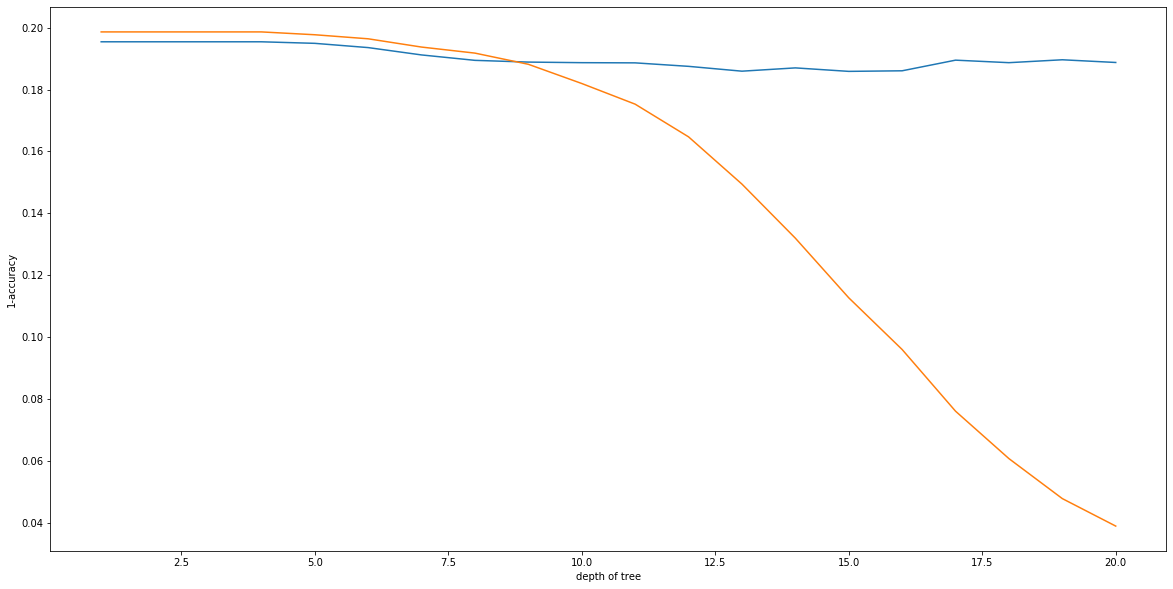

In [97]:
X = []
valid = []
train = []

for i in range(1,21) :
    rf = RandomForestClassifier(random_state=1, n_estimators=20, n_jobs=4, max_depth=i)
    rf.fit(x_train_, y_train_)
    X.append(i)
    train.append(1 - accuracy_score(y_train_, rf.predict(x_train_)))
    valid.append(1 - accuracy_score(y_test, rf.predict(x_test)))
    
plt.figure(figsize=(20,10))
plt.xlabel('depth of tree')
plt.ylabel('1-accuracy')
# plt.title('ROC Curve')
plt.plot(X, valid)
plt.plot(X, train)
plt.show()

In [92]:
y_train

99497     0
62972     1
8992      0
560341    4
376611    0
         ..
600894    2
296888    3
451228    4
817434    4
313043    4
Name: rating, Length: 64000, dtype: int64

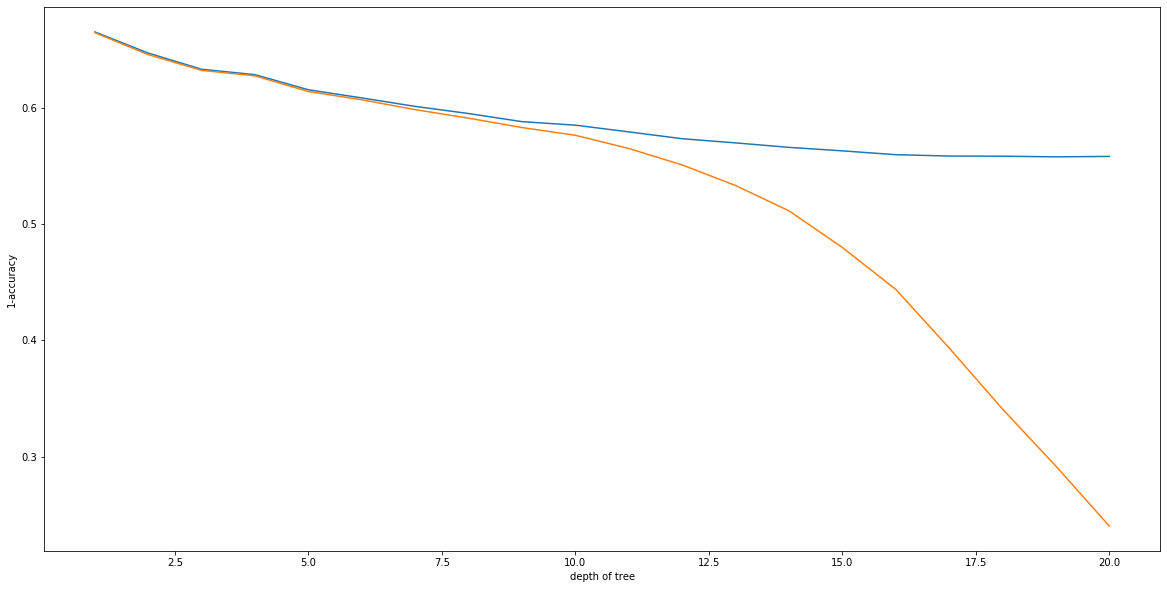

In [0]:
plt.figure(figsize=(20,10))
plt.xlabel('depth of tree')
plt.ylabel('1-accuracy')
# plt.title('ROC Curve')
plt.plot(X, valid)
plt.plot(X, train)
plt.show()

In [0]:
from sklearn.metrics import roc_curve, auc

In [19]:
def f(x) :
    return 2 if x > 1 else 1
df_['rating'] = df_['rating'].map(lambda x: f(x))
df_

,rating,cluster_pt_0,cluster_pt_1,cluster_pt_2,cluster_pt_3,cluster_pt_4,cluster_pt_5,cluster_pt_6,cluster_pt_7,cluster_pt_8,cluster_pt_9,cluster_pt_10,cluster_pt_11,cluster_pt_12,cluster_pt_13,cluster_pt_14,cluster_pt_15,cluster_pt_16,cluster_pt_17,cluster_pt_18,cluster_pt_19,cluster_pt_20,cluster_pt_21,cluster_pt_22,cluster_pt_23,cluster_pt_24,cluster_pt_25,cluster_sc_0,cluster_sc_1,cluster_sc_2,cluster_sc_3,cluster_sc_4,cluster_sc_5,cluster_sc_6,cluster_sc_7,cluster_sc_8,cluster_sc_9,cluster_sc_10,cluster_sc_11,cluster_sc_12,...,Transhumanism,Transportation,Trivia,Turn-Based,Turn-Based Combat,Turn-Based Strategy,Turn-Based Tactics,Tutorial,Twin Stick Shooter,Typing,Underground,Underwater,Unforgiving,Utilities,VR,Vampire,Vehicular Combat,Video Production,Villain Protagonist,Violent,Visual Novel,Voice Control,Voxel,Walking Simulator,War,Wargame,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,eSports,player,Q3,Q2,Q1
963430,2,273.0,9154.0,249.0,11718.0,4748.0,1.0,0.0,16111.0,1843.0,48.0,67.0,15454.0,936.0,0.0,127.0,93.0,2.0,1719.0,42.0,307.0,1861.0,5032.0,9083.0,1408.0,41275.0,0.0,2.437751,2.066888,1.348615,2.630203,2.722842,0.301030,0.000000,2.334551,2.198093,1.690196,1.832509,2.704410,2.651805,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1160,814.00,494.0,318.00
154806,2,3568.0,77554.0,5598.0,15585.0,35962.0,15332.0,2302.0,27636.0,3701.0,2934.0,6606.0,8199.0,2911.0,2864.0,5173.0,8609.0,7837.0,5611.0,7679.0,1405.0,8623.0,10386.0,40800.0,72167.0,108486.0,2858.0,2.363853,2.275243,2.443828,2.392233,2.387119,2.484258,2.035819,2.563739,2.287377,2.008395,2.365648,2.368117,2.116258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1719,1305.50,548.0,247.00
1257507,1,3283.0,14741.0,171.0,1093.0,32508.0,794.0,162.0,1287.0,1332.0,50.0,667.0,59.0,2408.0,1608.0,2762.0,2506.0,4856.0,4994.0,1607.0,0.0,7492.0,898.0,41655.0,92.0,1716.0,16.0,1.973824,1.782230,0.925576,1.344467,1.902543,1.345538,1.382415,1.463182,2.547642,1.311625,1.513081,0.883759,1.735830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,926,3613.50,1188.0,400.00
534124,2,3666.0,57921.0,11332.0,8460.0,88910.0,55994.0,5618.0,10520.0,3912.0,5830.0,533.0,23573.0,668.0,1266.0,19475.0,6956.0,36494.0,11194.0,21903.0,973.0,19431.0,7287.0,36378.0,80391.0,34462.0,20156.0,2.581616,2.942598,2.714004,2.452876,3.681446,3.297383,3.012780,2.899005,2.977907,3.106156,2.727541,2.658533,2.218093,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,675,405.25,270.5,195.75
429786,2,1124.0,17850.0,20744.0,7435.0,51996.0,79983.0,20277.0,17901.0,15.0,2546.0,1907.0,13283.0,3577.0,65.0,4302.0,3437.0,16637.0,4989.0,34303.0,405.0,15977.0,3178.0,25377.0,13109.0,11852.0,6138.0,2.697967,2.271029,2.942307,2.249533,3.360248,3.033711,2.672642,2.560047,1.204120,2.518942,2.010969,2.398203,2.094905,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,742,704.50,341.0,225.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166898,2,347.0,23060.0,71.0,14230.0,3925.0,1032.0,0.0,2870.0,321.0,946.0,809.0,1340.0,454.0,0.0,7897.0,0.0,0.0,2759.0,142.0,3107.0,5338.0,6583.0,10312.0,636.0,16874.0,65.0,2.541579,2.386148,1.265739,2.590886,2.474471,3.014100,0.000000,2.311802,1.566972,2.332161,1.972241,2.669146,2.118331,.

In [0]:
X = df_.iloc[:, 1:]
y = df_['rating'] - 1

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=1)

In [61]:
rf = RandomForestClassifier(random_state= 1, n_estimators=20, n_jobs=4, max_depth=15) # n_estimators: 몇 번 디시젼 트리 만들건지
rf.fit(x_train, y_train)
accuracy_score(y_test, rf.predict(x_test))

0.806375

In [0]:
dt = DecisionTreeClassifier()

In [24]:
dt.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [25]:
accuracy_score(y_test, dt.predict(x_test))

0.736625

In [52]:
from sklearn.metrics import confusion_matrix

conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, rf.predict(X_test)),
    columns=['Pred 1', 'Pred 2', 'Pred 3', 'Pred 4', 'Pred 5'],
    index=['True 1', 'True 2', 'True 3', 'True 4', 'True 5'])

conf_matrix

,Pred 1,Pred 2,Pred 3,Pred 4,Pred 5
True 1,33672,10043,5044,6197,5711
True 2,16525,19061,10507,7562,6633
True 3,9649,11606,22887,9613,6503
True 4,9627,7921,10260,19240,13411
True 5,5572,3876,3679,10090,37073


In [0]:
fpr, tpr, _ = roc_curve(y_test, xgb.predict_proba(x_test)[:,1])

In [37]:
xgb.predict_proba(x_test)

array([[0.06820089, 0.9317991 ],
       [0.26035047, 0.73964953],
       [0.06581956, 0.93418044],
       ...,
       [0.04334015, 0.95665985],
       [0.21636504, 0.78363496],
       [0.3276102 , 0.6723898 ]], dtype=float32)

ROC AUC: 0.77


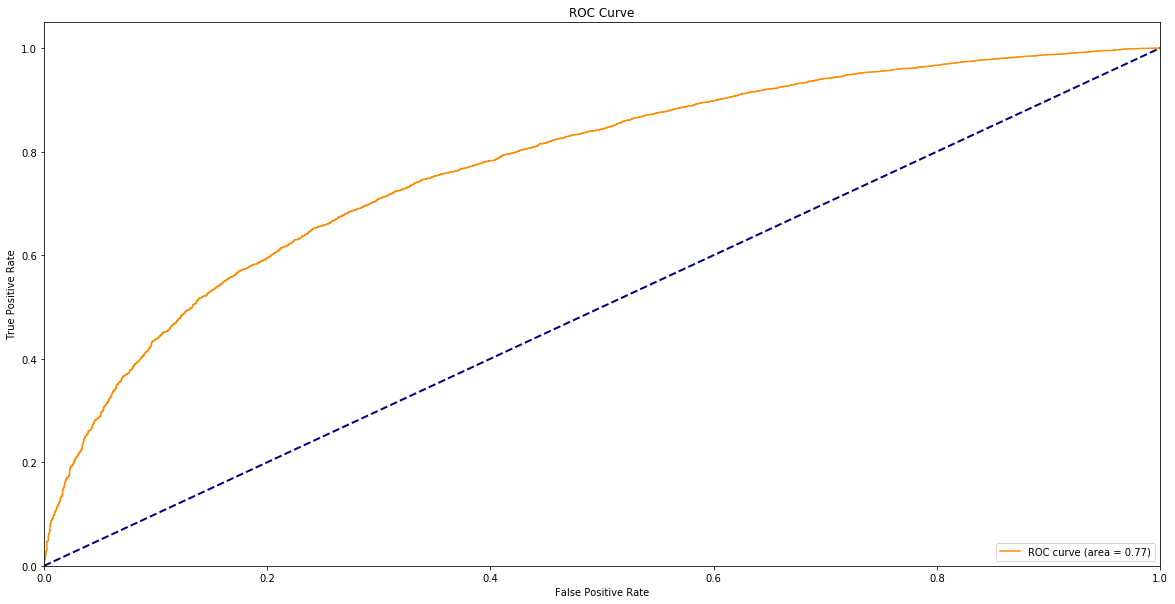

In [38]:
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print ('ROC AUC: %0.2f' % roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure(figsize=(20,10))
# plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
# 모양 예쁘게 나와서 분석해놓고 보여줄 때? 하고 싶으면 더 알아보라고 함

In [32]:
from sklearn.metrics import plot_roc_curve
ax = plt.gca()
rfc_disp = plot_roc_curve(rfc, x_test, y_test, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

ImportError: ignored

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
fpr = dict()
tpr = dict()
roc_auc = dict()
y_score = dt.predict_proba(x_test)
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

ValueError: ignored